# Code from Part 1 Exercise - Satellite Imagery Data Preparation



In [1]:
!pip install patchify

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [4]:
minmaxscaler = MinMaxScaler()

In [5]:
!ls -lah '/content/drive/MyDrive/Semantic segmentation dataset'

total 33K
-rw------- 1 root root  548 Jan 26 02:18  classes.json
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 1'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 2'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 3'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 4'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 5'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 6'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 7'
drwx------ 2 root root 4.0K Jan 26 02:22 'Tile 8'


In [6]:
dataset_root_folder = '/content/drive/MyDrive'

In [7]:
dataset_name = "Semantic segmentation dataset"

In [8]:
image_patch_size = 256

In [9]:
#Reading and Processing Satellite Images
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        #Patchify Images
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape) convert into vector,normalizing & restore matrix
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [11]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [12]:
type(image_dataset[0])

numpy.ndarray

In [13]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

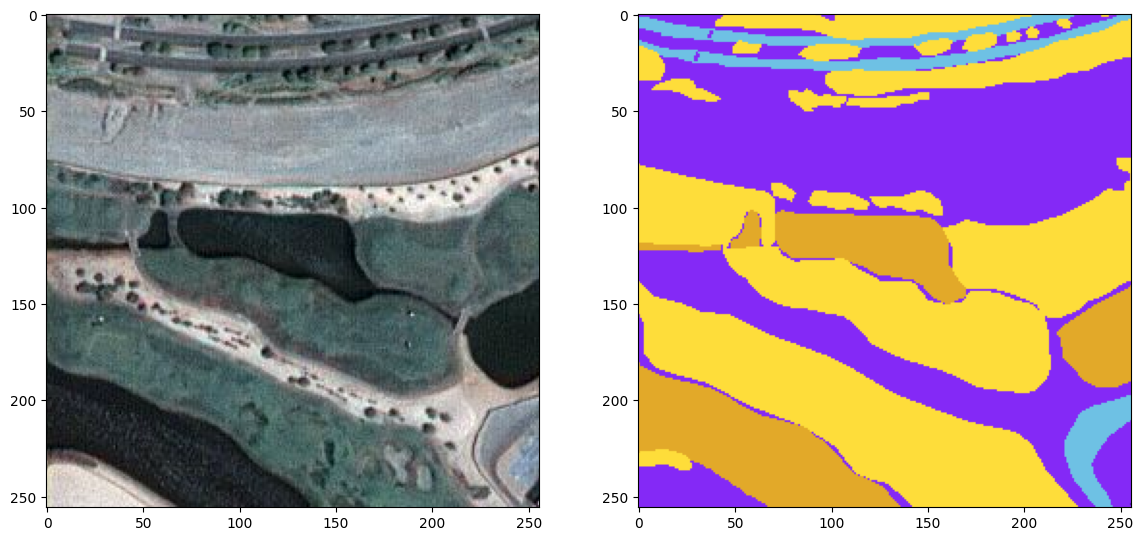

In [14]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8)) #width,height
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [15]:
#Processing labels
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [16]:
label = individual_patched_mask

In [17]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [18]:
#Creating RGB2Label
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [19]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [20]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [21]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


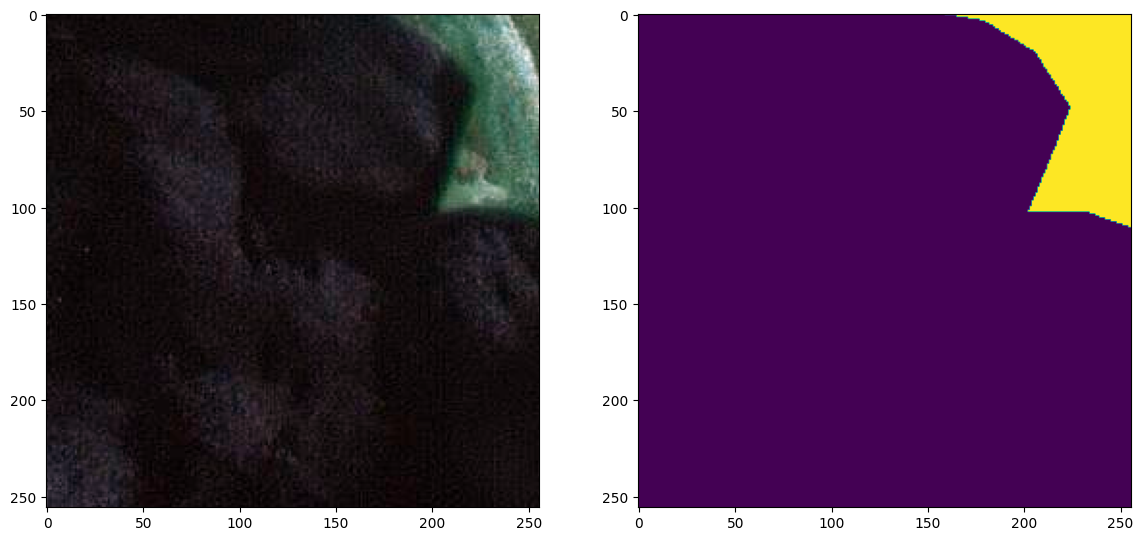

In [22]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [23]:
total_classes = len(np.unique(labels))

In [24]:
total_classes

6

In [25]:
from tensorflow.keras.utils import to_categorical

In [26]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [27]:
#Creating Training and Test Data
master_trianing_dataset = image_dataset

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [31]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [32]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [33]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [34]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [35]:
from keras import backend as K

In [36]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [37]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels)) #defines the input layer of the neural network, creaters a tensor of the specified dimensions

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [38]:
metrics = ["accuracy", jaccard_coef]

In [39]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [40]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [41]:
model = get_deep_learning_model()

In [42]:
# uncomment this line to get model configuration
# model.get_config()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [43]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [44]:
!pip show segmentation_models

Name: segmentation-models
Version: 1.0.1
Summary: Image segmentation models with pre-trained backbones with Keras.
Home-page: https://github.com/qubvel/segmentation_models
Author: Pavel Yakubovskiy
Author-email: qubvel@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: efficientnet, image-classifiers, keras-applications
Required-by: 


In [45]:
import os
print(os.environ.get('SM_FRAMEWORK'))

None


In [46]:
!pip install -q tensorflow

In [47]:
!pip install -q keras
import os
os.environ["SM_FRAMEWORK"]="tf.keras"

In [48]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [49]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [50]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [51]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [52]:
import tensorflow as tf

In [53]:
tf.keras.backend.clear_session()


In [54]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [56]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=5,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/5
51/51 [==============================] - 50s 385ms/step - loss: 0.9991 - accuracy: 0.5787 - jaccard_coef: 0.2785 - val_loss: 0.9908 - val_accuracy: 0.6625 - val_jaccard_coef: 0.3445
Epoch 2/5
51/51 [==============================] - 11s 206ms/step - loss: 0.9796 - accuracy: 0.6485 - jaccard_coef: 0.3759 - val_loss: 0.9642 - val_accuracy: 0.7031 - val_jaccard_coef: 0.4563
Epoch 3/5
51/51 [==============================] - 11s 208ms/step - loss: 0.9603 - accuracy: 0.7240 - jaccard_coef: 0.4760 - val_loss: 0.9683 - val_accuracy: 0.7064 - val_jaccard_coef: 0.4662
Epoch 4/5
51/51 [==============================] - 11s 213ms/step - loss: 0.9525 - accuracy: 0.7489 - jaccard_coef: 0.5047 - val_loss: 0.9698 - val_accuracy: 0.6966 - val_jaccard_coef: 0.4787
Epoch 5/5
51/51 [==============================] - 11s 212ms/step - loss: 0.9487 - accuracy: 0.7567 - jaccard_coef: 0.5204 - val_loss: 0.9674 - val_accuracy: 0.7021 - val_jaccard_coef: 0.4926


In [57]:
history_a = model_history

In [58]:
history_a.history

{'loss': [0.9991421699523926,
  0.9796273112297058,
  0.9602649807929993,
  0.9525482654571533,
  0.9487191438674927],
 'accuracy': [0.5787381529808044,
  0.6485080122947693,
  0.7239545583724976,
  0.7489429712295532,
  0.7566940784454346],
 'jaccard_coef': [0.2784885764122009,
  0.37590500712394714,
  0.4759964942932129,
  0.5047289729118347,
  0.5203941464424133],
 'val_loss': [0.9908396601676941,
  0.9641867876052856,
  0.9683128595352173,
  0.9697900414466858,
  0.9673954248428345],
 'val_accuracy': [0.66253262758255,
  0.7031224370002747,
  0.70636385679245,
  0.696614682674408,
  0.7021215558052063],
 'val_jaccard_coef': [0.3445187211036682,
  0.45629316568374634,
  0.46615707874298096,
  0.478739857673645,
  0.4925795793533325]}

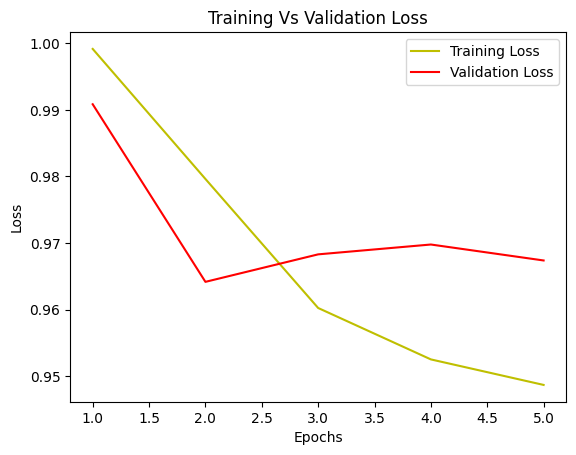

In [60]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [61]:
loss_a = model_history

In [62]:
loss_a.history

{'loss': [0.9991421699523926,
  0.9796273112297058,
  0.9602649807929993,
  0.9525482654571533,
  0.9487191438674927],
 'accuracy': [0.5787381529808044,
  0.6485080122947693,
  0.7239545583724976,
  0.7489429712295532,
  0.7566940784454346],
 'jaccard_coef': [0.2784885764122009,
  0.37590500712394714,
  0.4759964942932129,
  0.5047289729118347,
  0.5203941464424133],
 'val_loss': [0.9908396601676941,
  0.9641867876052856,
  0.9683128595352173,
  0.9697900414466858,
  0.9673954248428345],
 'val_accuracy': [0.66253262758255,
  0.7031224370002747,
  0.70636385679245,
  0.696614682674408,
  0.7021215558052063],
 'val_jaccard_coef': [0.3445187211036682,
  0.45629316568374634,
  0.46615707874298096,
  0.478739857673645,
  0.4925795793533325]}

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
model_history.params

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
len(y_pred)

In [ ]:
y_pred

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

In [ ]:
y_pred_argmax

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [ ]:
import random


In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
model.save("satellite_segmentation.keras")

In [ ]:
!ls -lah